In [184]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [185]:
data_path = os.path.expanduser('Data/Data1.csv')
df = pd.read_csv(data_path, comment='#')
df.rename(columns={
    'Timestamp': 'timestamp',
    'Royal Canin Lowfat Can (13.6oz)': 'can',
    'Sweet Potato (11.5oz)': 'sweet',
    'Golden Potato (5.2oz)': 'golden',
    'Outcome': 'outcome',
    'Were We Sleeping / Jake Was Alone Just Before': 'alone',
    'Was it an Accident?': 'accident',
    'Notes': 'notes',
    'Poop Event': 'poop',
    'Feed Event': 'feed'
}, inplace=True)
df.head()

,timestamp,can,sweet,golden,outcome,alone,accident,notes,poop,feed
0,1545929878,2.0,1.0,1.0,NaN,NaN,NaN,NaN,False,True
1,1545930646,NaN,NaN,NaN,2.0,NaN,NaN,Outside,True,False
2,1545943282,2.0,1.0,1.0,NaN,NaN,NaN,NaN,False,True
3,1545948608,NaN,NaN,NaN,2.0,NaN,NaN,Outside,True,False
4,1545948875,NaN,NaN,NaN,NaN,NaN,NaN,Jake got 2 gabapentin at lunch and 2 at 2pm. O...,False,True


In [186]:
# This was done once on the original dataset. No longer necessary
# def to_timestamp(t):
#     dt = datetime.strptime(t, '%m/%d/%Y %H:%M:%S')
#     return dt.strftime('%s')
# df.timestamp = [to_timestamp(t) for t in df.timestamp.values]

# set(df.outcome)
# renames = {'Big One': 3, 'Regular': 2, 'No Poop': 0}
# for k, v in renames.items():
#     df.loc[df.outcome == k, 'outcome'] = v


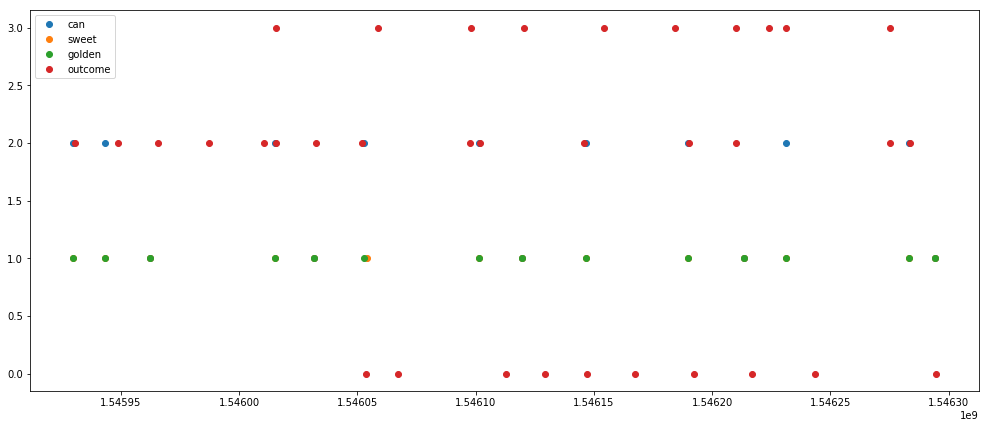

In [187]:
plt.figure(figsize=(17, 7))
plt.plot(df.timestamp, df.can, 'o', alpha=1, label='can')
plt.plot(df.timestamp, df.sweet, 'o', alpha=1, label='sweet')
plt.plot(df.timestamp, df.golden, 'o', alpha=1, label='golden')
plt.plot(df.timestamp, df.outcome, 'o', alpha=1.0, label='outcome')
plt.legend()
plt.show()


In [188]:
ddf = df.copy()
ddf.loc[df.index, 'poop'] = False
ddf.loc[df.index, 'feed'] = True
ddf.loc[df.outcome >= 0, 'poop'] = True
ddf.loc[df.outcome >= 0, 'feed'] = False
ddf.loc[df.alone == 'Yes', 'alone'] = True
ddf.loc[df.accident == 'Yes', 'accident'] = True
df = ddf

In [189]:
def accumulate_pastdata(df, hours_ago=24, span=3):
    x = 0; y = 0
    df = df.sort_values(by='timestamp')
    for index, row in df.iterrows():
        if not row.poop:
            continue
        dt = datetime.fromtimestamp(row.timestamp)
        df.loc[index, 'hour_of_day'] = dt.hour
        for h in range(span, hours_ago + span, span):
            start = row.timestamp - (h * 3600)
            end = row.timestamp - (h - span) * 3600
            ddf = df[(df.timestamp > start) & (df.timestamp < end)]
            s = ddf.sum()
            start_str = h - span
            end_str = h
            df.loc[index, 'golden_{}_to_{}'.format(start_str, end_str)] = s.golden
            df.loc[index, 'can_{}_to_{}'.format(start_str, end_str)] = s.can
            df.loc[index, 'sweet_{}_to_{}'.format(start_str, end_str)] = s.sweet
            df.loc[index, 'outcome_{}_to_{}'.format(start_str, end_str)] = s.outcome  
    return df
    

ddf = accumulate_pastdata(df.copy())
ddf.head()

,timestamp,can,sweet,golden,outcome,alone,accident,notes,poop,feed,...,sweet_15_to_18,outcome_15_to_18,golden_18_to_21,can_18_to_21,sweet_18_to_21,outcome_18_to_21,golden_21_to_24,can_21_to_24,sweet_21_to_24,outcome_21_to_24
0,1545929878,2.0,1.0,1.0,NaN,NaN,NaN,NaN,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1545930646,NaN,NaN,NaN,2.0,NaN,NaN,Outside,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1545943282,2.0,1.0,1.0,NaN,NaN,NaN,NaN,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1545948608,NaN,NaN,NaN,2.0,NaN,NaN,Outside,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1545948875,NaN,NaN,NaN,NaN,NaN,NaN,Jake got 2 gabapentin at lunch and 2 at 2pm. O...,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ddf.to_csv('Data/Data1.processed.csv')

Index(['timestamp', 'can', 'sweet', 'golden', 'outcome', 'alone', 'accident',
       'notes', 'poop', 'feed', 'hour_of_day', 'golden_0_to_3', 'can_0_to_3',
       'sweet_0_to_3', 'outcome_0_to_3', 'golden_3_to_6', 'can_3_to_6',
       'sweet_3_to_6', 'outcome_3_to_6', 'golden_6_to_9', 'can_6_to_9',
       'sweet_6_to_9', 'outcome_6_to_9', 'golden_9_to_12', 'can_9_to_12',
       'sweet_9_to_12', 'outcome_9_to_12', 'golden_12_to_15', 'can_12_to_15',
       'sweet_12_to_15', 'outcome_12_to_15', 'golden_15_to_18', 'can_15_to_18',
       'sweet_15_to_18', 'outcome_15_to_18', 'golden_18_to_21', 'can_18_to_21',
       'sweet_18_to_21', 'outcome_18_to_21', 'golden_21_to_24', 'can_21_to_24',
       'sweet_21_to_24', 'outcome_21_to_24'],
      dtype='object')


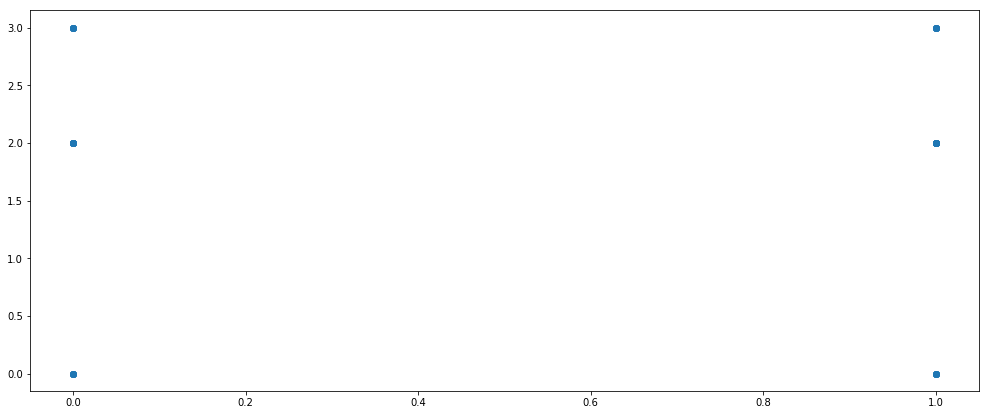

In [190]:
plt.figure(figsize=(17, 7))
print(ddf.columns)
pdf = ddf[ddf.poop == True]
plt.plot(pdf.sweet_0_to_3, pdf.outcome, 'o')

In [272]:
#Classifier

feature_clumns = [c for c in ddf.columns if re.search(c, '_to_')] + ['hour_of_day']
ddf = ddf[ddf.index >= 8]  # cut out beginning of data set
X = ddf.loc[ddf.poop, feature_columns].values
Y = ddf.outcome[ddf.poop].values > 0
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, Y)
scores = cross_val_score(clf, X, Y, cv=10)

scores.mean()

0.7

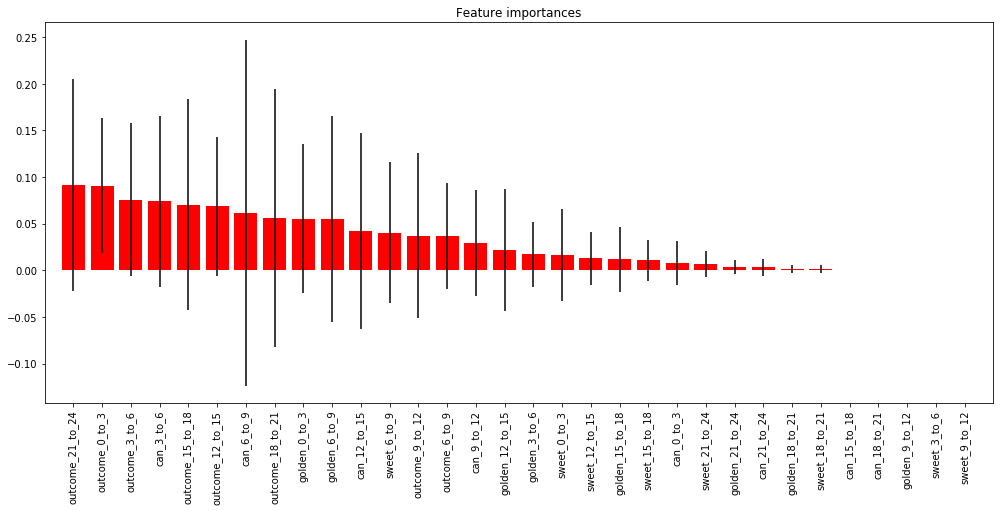

Feature ranking:
1. feature outcome_21_to_24 (0.091600)
2. feature outcome_0_to_3 (0.090822)
3. feature outcome_3_to_6 (0.075899)
4. feature can_3_to_6 (0.073983)
5. feature outcome_15_to_18 (0.070546)
6. feature outcome_12_to_15 (0.068747)
7. feature can_6_to_9 (0.061820)
8. feature outcome_18_to_21 (0.055777)
9. feature golden_0_to_3 (0.055322)
10. feature golden_6_to_9 (0.055193)
11. feature can_12_to_15 (0.042260)
12. feature sweet_6_to_9 (0.040538)
13. feature outcome_9_to_12 (0.037243)
14. feature outcome_6_to_9 (0.036780)
15. feature can_9_to_12 (0.029152)
16. feature golden_12_to_15 (0.021740)
17. feature golden_3_to_6 (0.017041)
18. feature sweet_0_to_3 (0.016316)
19. feature sweet_12_to_15 (0.012783)
20. feature golden_15_to_18 (0.011742)
21. feature sweet_15_to_18 (0.010837)
22. feature can_0_to_3 (0.007828)
23. feature sweet_21_to_24 (0.006629)
24. feature golden_21_to_24 (0.003517)
25. feature can_21_to_24 (0.003075)
26. feature golden_18_to_21 (0.001404)
27. feature sweet

In [233]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
display_columns = np.array(feature_columns)
fig, ax = plt.subplots(1, 1, figsize=(17, 7))
ax.set_title("Feature importances")
ax.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
ax.set_xticks(range(X.shape[1]))
ax.set_xlim([-1, X.shape[1]])
ax.set_xticklabels(display_columns[indices])
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, display_columns[indices[f]], importances[indices[f]]))